### Implementing Residual connection_ with large batch size-extra layer
##### 3 GCN layer

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import deepchem as dc
import os
from tqdm import tqdm
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch.nn import BatchNorm1d

C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GCNLayer(nn.Module):
    
    def __init__(self,in_feats,out_feats,batch_norm=True):
        
        super().__init__()
        self.graph_conv = GCNConv(in_channels=in_feats,out_channels=out_feats)
        self.dropout = nn.Dropout(p=0.6)
        self.batch_norm = batch_norm
        
        ## implementing residual
        self.res_connection = nn.Linear(in_feats,out_feats)
        
        ## implementing BatchNorm
        if self.batch_norm:
            self.bn = BatchNorm1d(out_feats)
        
    def reset_parameters(self):
        """Reinitialize model parameters."""
        self.graph_conv.reset_parameters()
        self.res_connection.reset_parameters()
          
    def forward(self,x,edge_index):
        
        ### Extracting data from batch
        new_feats = self.graph_conv(x,edge_index)
        res_feats = F.relu(self.res_connection(x))
        new_feats = new_feats + res_feats ### residual added
        #new_feats = self.dropout(new_feats)
        
        if self.batch_norm:
            return self.bn(new_feats)
        else:
            return new_feats

In [3]:
class GCNNetwork(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        ## GCN layers
        self.GCNConv1 = GCNLayer(30,64,batch_norm=False) ## Putting batch norm false
        self.GCNConv2 = GCNLayer(64,64,batch_norm=False) ## adding a layer of 64 to 64
#         self.GCNConv3 = GCNLayer(64,32,batch_norm=False)

        ### Predictor layers
        self.lin1 = nn.Linear(64,128)
        self.lin2 = nn.Linear(128,1)
        
        
    def forward(self,data):
        
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        
        x = F.relu(self.GCNConv1(x,edge_index))
        x = F.relu(self.GCNConv2(x,edge_index))
#         x = F.relu(self.GCNConv3(x,edge_index))
        
        x = global_mean_pool(x,batch)
        
        x = F.relu(self.lin1(x))
        x = torch.sigmoid(self.lin2(x))
        
        return x      

In [4]:
### Old with our refinement
##clean_data = pd.read_csv(r"Data.csv")

In [5]:
## same data use for p-gp interaction and Refined Docking
clean_data = pd.read_csv("FinalClearData-refined.csv")

In [6]:
data = clean_data

In [7]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

In [8]:
class BBBDataset(Dataset):
    
    def __init__(self,root,transform=None,pre_transform=None,pre_filter=None):
        
        super().__init__(root, transform, pre_transform, pre_filter)
        
        
        
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "FinalClearData-refined.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        smiles = self.data.SMILES.to_list()
        labels = self.data.LABELS.to_list()
        
        featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
        X = featurizer.featurize(smiles)
        
        j=0
        for idx, Gdata in tqdm(enumerate(X)):
            
            pyG_data = Gdata
            
            nodes = torch.tensor(pyG_data.node_features,dtype= torch.float32)
            
            Edge_index = torch.tensor(pyG_data.edge_index,dtype= torch.int64 )
            #Edge_feats = torch.tensor(pyG_data.edge_features,dtype=torch.float32)
            y = torch.tensor([labels[idx]],dtype= torch.float32 )
            ### create data object
            data = Data(x=nodes,edge_index=Edge_index,y=y,smiles=smiles[idx])
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data


In [9]:
dataset = BBBDataset(root=".",)

Processing...
3011it [00:02, 1353.16it/s]
Done!


In [10]:
# ### Splitting of data
# from torch.utils.data import random_split

# train_set, test_set = random_split(dataset,[2000,1011]) ## 70:30

# trainloader = DataLoader(train_set,shuffle=True,batch_size=256,) ## TrainLoader
# testloader = DataLoader(test_set, shuffle=True,batch_size=256,)  ## TestLoader

In [11]:
#### combined loader:
loaders = (trainloader,testloader)

### Metrics

In [10]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,precision_score,recall_score

In [11]:
## Base Metircs to convert probablity to binary
def base_metrics(y_prob,y_true):
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    
    return (np.array(y_true),y_prob)

In [12]:
## accuracy counter
def accuracy_counter(y_true,y_prob):
    return accuracy_score(y_true,y_prob)    

In [13]:
### F1_scorer
def f1_scorer(y_true,y_prob):
    return f1_score(y_true,y_prob)

In [14]:
### Precision
def precision_counter(y_true,y_prob):
    return precision_score(y_true,y_prob)

In [15]:
### Recall score
def recall_counter(y_true,y_prob):
    return recall_score(y_true,y_prob)
    

In [16]:
### ROC
def roc_auc_scorer(y_true,y_prob):
    return roc_auc_score(y_true,y_prob)

### Train/Test

##### Implementing Early stopping

In [17]:
# from TorchTools import EarlyStopping
# ## initialize the early_stopping object
# early_stopping = EarlyStopping(patience=20, verbose=True,path="GCNcheckpoint.pt")

In [18]:
def train(model,optimizer,criterion,train_loader):
    
    model.train() ### training mode
    
    y_true = []
    proab = []
    train_loss = []
    for data in train_loader:## Iterate in batches over training dataset
        data.to(device)
        
        optimizer.zero_grad() ## clear gradients
        out = model(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
        
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        
        train_loss.append(loss)
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        
    av_loss = torch.sum(torch.tensor(train_loss))/len(train_loader)
    
    ## metrics
    true,proab = base_metrics(proab,y_true)
    accuracy = accuracy_counter(true,proab)
    f1_Score = f1_scorer(true,proab)
    roc_Score = roc_auc_scorer(true,proab)
    Recall_score = recall_counter(true,proab)
    Precsion_score = precision_counter(true,proab)
    
    return (av_loss,accuracy,f1_Score,roc_Score,Recall_score,Precsion_score)
        

In [19]:
@torch.no_grad()
def test(model,criterion,test_loader):
    
    model.eval() #### evaluation mode
    
    y_true = []
    proab = []
    val_loss = []
    for data in test_loader:## Iterate in batches over training dataset
        data.to(device)
        out = model(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
        
    val = torch.sum(torch.tensor(val_loss))/len(test_loader)
    
    ## metrics
    #accuracy = accuracy_counter(proab,y_true)
    true,proab = base_metrics(proab,y_true)
    accuracy = accuracy_counter(true,proab)
    f1_Score = f1_scorer(true,proab)
    roc_Score = roc_auc_scorer(true,proab)
    Recall_score = recall_counter(true,proab)
    Precsion_score = precision_counter(true,proab)
    
    
    return (val,accuracy,f1_Score,roc_Score,Recall_score,Precsion_score)

In [20]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

# ## Intilaize Network
# model = GCNNetwork()

# ### initialize an optimizer with someparameters
# # optimizer = torch.optim.Adam(net.parameters(), lr=0.001,) ## Weight decay might be reason for low validation loss than training
#                                                 ## 5ncrease learning rate 0.5

# ### Defining loss
# criterion = BCELoss()

# ### criterion
# criterion.cuda()

# ## shifting to GPU
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

#### Setting up tune

In [21]:
from ray import tune
from ray.tune.schedulers import ASHAScheduler

In [22]:
def train_Graph(config):
    
    ### Splitting of data
    from torch.utils.data import random_split

    train_set, test_set = random_split(dataset,[2000,1011]) ## 70:30

    trainloader = DataLoader(train_set,shuffle=True,batch_size=256,) ## TrainLoader
    testloader = DataLoader(test_set, shuffle=True,batch_size=256,)  ## TestLoader
    
    
    ## Intilaize Network
    model = GCNNetwork()
    
    ### Defining loss
    criterion = BCELoss()
    
    ### criterion
    criterion.cuda()
    
    ## shifting to GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    
    ### initialize an optimizer with someparameters
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"],)
    
    for i in range(10):
        train_res = train(model, optimizer,criterion,trainloader)
        test_res = test(model,criterion,testloader)
        
        # Send the current training result back to Tune
        tune.report(mean_accuracy=test_res[1])

In [23]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
}

In [24]:
import numpy as np
analysis = tune.run(train_Graph, config=search_space,fail_fast="raise",resources_per_trial={'gpu': 1},)

2022-07-22 16:50:16,900	WARNING function_runner.py:603 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-07-22 16:50:16,921	INFO logger.py:630 -- pip install "ray[tune]" to see TensorBoard files.
2022-07-22 16:50:16,922	WARNING callback.py:105 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\tune\trial_runner.py:324: UserWarning: fail_fast='raise' detected. Be careful when using this mode as resources (such as Ray processes, file descriptors, and temporary files) may not be cleaned up properly. To use a safer mode, use fail_fast=True.
  warnings.warn(
2022-07-22 16:

Trial name,status,loc,lr
train_Graph_99a7c_00000,RUNNING,127.0.0.1:11868,1.19681e-09


2022-07-22 16:50:26,760	ERROR trial_runner.py:883 -- Trial train_Graph_99a7c_00000: Error processing event.
(train_Graph pid=11868) 2022-07-22 16:50:26,672	ERROR function_runner.py:286 -- Runner Thread raised error.
(train_Graph pid=11868) Traceback (most recent call last):
(train_Graph pid=11868)   File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\tune\function_runner.py", line 277, in run
(train_Graph pid=11868)     self._entrypoint()
(train_Graph pid=11868)   File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\tune\function_runner.py", line 349, in entrypoint
(train_Graph pid=11868)     return self._trainable_func(
(train_Graph pid=11868)   File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\util\tracing\tracing_helper.py", line 462, in _resume_span
(train_Graph pid=11868)     return method(self, *_args, **_kwargs)
(train_Graph pid=11868)   File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\

RayTaskError(FileNotFoundError): [36mray::ImplicitFunc.train()[39m (pid=11868, ip=127.0.0.1, repr=train_Graph)
  File "python\ray\_raylet.pyx", line 665, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 669, in ray._raylet.execute_task
  File "python\ray\_raylet.pyx", line 616, in ray._raylet.execute_task.function_executor
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\_private\function_manager.py", line 675, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\util\tracing\tracing_helper.py", line 462, in _resume_span
    return method(self, *_args, **_kwargs)
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\tune\trainable.py", line 360, in train
    result = self.step()
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\util\tracing\tracing_helper.py", line 462, in _resume_span
    return method(self, *_args, **_kwargs)
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\tune\function_runner.py", line 404, in step
    self._report_thread_runner_error(block=True)
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\util\tracing\tracing_helper.py", line 462, in _resume_span
    return method(self, *_args, **_kwargs)
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\tune\function_runner.py", line 574, in _report_thread_runner_error
    raise e
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\tune\function_runner.py", line 277, in run
    self._entrypoint()
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\tune\function_runner.py", line 349, in entrypoint
    return self._trainable_func(
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\util\tracing\tracing_helper.py", line 462, in _resume_span
    return method(self, *_args, **_kwargs)
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\ray\tune\function_runner.py", line 645, in _trainable_func
    output = fn()
  File "C:\Users\Y-8874~1.EST\AppData\Local\Temp/ipykernel_29564/2829206187.py", line 29, in train_Graph
  File "C:\Users\Y-8874~1.EST\AppData\Local\Temp/ipykernel_29564/2506558855.py", line 8, in train
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\torch\utils\data\dataloader.py", line 521, in __next__
    data = self._next_data()
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\torch\utils\data\dataloader.py", line 561, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\torch\utils\data\dataset.py", line 363, in __getitem__
    return self.dataset[self.indices[idx]]
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\torch_geometric\data\dataset.py", line 197, in __getitem__
    data = self.get(self.indices()[idx])
  File "C:\Users\Y-8874~1.EST\AppData\Local\Temp/ipykernel_29564/3786838498.py", line 54, in get
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\torch\serialization.py", line 594, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\torch\serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\torch\serialization.py", line 211, in __init__
    super(_open_file, self).__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: '.\\processed\\data_2475.pt'

In [31]:
torch.__version__

'1.10.2'

In [37]:
from lrcurve import PlotLearningCurve
import numpy as np
epochs = 200

############# RealTime Plotting ###################

plot = PlotLearningCurve(
    mappings = {
        'loss': { 'line': 'train', 'facet': 'loss' },
        'val_loss': { 'line': 'validation', 'facet': 'loss' },
        'acc': { 'line': 'train', 'facet': 'acc' },
        'val_acc': { 'line': 'validation', 'facet': 'acc' },
        'F1_train':{'line':"train","facet":"F1"},
        'F1_val':{'line':"validation","facet":"F1"},
    },
    facet_config = {
        'loss': { 'name': 'Binary Cross-Entropy', 'limit': [0, None], 'scale': 'linear' },
        'acc': { 'name': 'Accuracy', 'limit': [0, 1], 'scale': 'linear' },
        'F1': { 'name': 'F1 score', 'limit': [0, 1], 'scale': 'linear' }
    },
    xaxis_config = { 'name': 'Epoch', 'limit': [0, 500] }
)



#############___________Metrics_________________
## Accuracy
traine_accuracy = []
vale_accuracy = []

### F1 score
train_f1 = []
test_f1 = []

### ROC score
train_roc = []
test_roc =  []

## Loss
epoch_loss = []
valida_loss = []

## Precision
train_pre = []
test_pre = []

## Recall
train_re = []
test_re = []



#######_________________________ Training_loop__________________

with plot:

    for epoch in range(1,epochs):

        train_loss1,train_accuracy1,train_f1_score,train_roc_score,re_score_train,pre_score_train = train()

        train_loss2,train_accuracy2,train_f1_score2,train_roc2,re_score_train2,pre_score_train2 = test(trainloader)

        val_loss,val_accuracy,val_f1,val_roc,re_score_val,pre_score_val = test(testloader)


        ##losses
        epoch_loss.append(train_loss1)
        valida_loss.append(val_loss)
        #test_loss_full.append(test_loss)

        ### f1_score
        train_f1.append(train_f1_score)
        test_f1.append(val_f1)

        #### ROC Score
        train_roc.append(train_roc_score)
        test_roc.append(val_roc)

        ## accuracy
        traine_accuracy.append(train_accuracy1)
        vale_accuracy.append(val_accuracy)

        ## Precisison
        train_pre.append(pre_score_train)
        test_pre.append(pre_score_val)

        ## Recall
        train_re.append(re_score_train)
        test_re.append(re_score_val)






        print(f"""Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}, Train accuracy: {train_accuracy1:.4f}, val loss: {val_loss:.4f}, val accuracy: {val_accuracy:.4f},
                  train F1: {train_f1_score}, val F1: {val_f1},train recall: {re_score_train}, val recall: {re_score_val}, train precision: {pre_score_train}, test precision:{pre_score_val}""")
        print()
        print()
        
        
        
        # append and update
        plot.append(epoch, {
            'loss': train_loss1,
            'val_loss': val_loss,
            'acc': train_accuracy1,
            'val_acc': val_accuracy,
            'F1_train':train_f1_score,
            'F1_val':val_f1,
        })
        plot.draw()     
    
    
#     # early_stopping needs the validation loss to check if it has decresed, 
#     # and if it has, it will make a checkpoint of the current model
#     early_stopping(val_loss, net)
    
#     if early_stopping.early_stop:
#             print("Early stopping")
#             break

Epoch: 001, Train loss: 0.6789, Train accuracy: 0.5949, val loss: 0.6663, val accuracy: 0.6068,
                  train F1: 0.7373371924746744, val F1: 0.7552674230145867,train recall: 0.9470260223048327, val recall: 1.0, train precision: 0.6036729857819905, test precision:0.6067708333333334


Epoch: 002, Train loss: 0.6711, Train accuracy: 0.5999, val loss: 0.6652, val accuracy: 0.6055,
                  train F1: 0.7499128008371121, val F1: 0.754257907542579,train recall: 1.0, val recall: 1.0, train precision: 0.5998883928571429, test precision:0.60546875


Epoch: 003, Train loss: 0.6664, Train accuracy: 0.5954, val loss: 0.6533, val accuracy: 0.6224,
                  train F1: 0.7464148303602658, val F1: 0.7672552166934189,train recall: 1.0, val recall: 1.0, train precision: 0.5954241071428571, test precision:0.6223958333333334


Epoch: 004, Train loss: 0.6608, Train accuracy: 0.6004, val loss: 0.6505, val accuracy: 0.6198,
                  train F1: 0.7501744591765527, val F1: 0.

Epoch: 028, Train loss: 0.5684, Train accuracy: 0.7093, val loss: 0.5645, val accuracy: 0.7070,
                  train F1: 0.7761065749892566, val F1: 0.7770069375619425,train recall: 0.8439252336448598, val recall: 0.843010752688172, train precision: 0.7183770883054893, test precision:0.7205882352941176


Epoch: 029, Train loss: 0.5593, Train accuracy: 0.7215, val loss: 0.5613, val accuracy: 0.7279,
                  train F1: 0.7814279456855016, val F1: 0.8026440037771481,train recall: 0.8367729831144465, val recall: 0.9100642398286938, train precision: 0.7329498767460969, test precision:0.7179054054054054


Epoch: 030, Train loss: 0.5570, Train accuracy: 0.7188, val loss: 0.5572, val accuracy: 0.7161,
                  train F1: 0.7806788511749347, val F1: 0.7947269303201506,train recall: 0.8367537313432836, val recall: 0.8791666666666667, train precision: 0.731647634584013, test precision:0.7250859106529209


Epoch: 031, Train loss: 0.5622, Train accuracy: 0.7126, val loss: 0.5763

Epoch: 055, Train loss: 0.5180, Train accuracy: 0.7327, val loss: 0.5366, val accuracy: 0.7344,
                  train F1: 0.7875831485587582, val F1: 0.7875,train recall: 0.8291316526610645, val recall: 0.7957894736842105, train precision: 0.75, test precision:0.7793814432989691


Epoch: 056, Train loss: 0.5142, Train accuracy: 0.7327, val loss: 0.5176, val accuracy: 0.7383,
                  train F1: 0.7905553126366419, val F1: 0.7917098445595855,train recall: 0.8278388278388278, val recall: 0.8076109936575053, train precision: 0.7564853556485356, test precision:0.7764227642276422


Epoch: 057, Train loss: 0.5119, Train accuracy: 0.7439, val loss: 0.5292, val accuracy: 0.7383,
                  train F1: 0.7906976744186047, val F1: 0.7987987987987988,train recall: 0.8148496240601504, val recall: 0.8435517970401691, train precision: 0.7679362267493357, test precision:0.7585551330798479


Epoch: 058, Train loss: 0.5195, Train accuracy: 0.7321, val loss: 0.5534, val accuracy: 0.7174,


Epoch: 082, Train loss: 0.5001, Train accuracy: 0.7511, val loss: 0.5446, val accuracy: 0.7292,
                  train F1: 0.7967183226982679, val F1: 0.8019047619047618,train recall: 0.813780260707635, val recall: 0.913232104121475, train precision: 0.7803571428571429, test precision:0.7147707979626485


Epoch: 083, Train loss: 0.4980, Train accuracy: 0.7522, val loss: 0.5253, val accuracy: 0.7422,
                  train F1: 0.797629899726527, val F1: 0.8180147058823529,train recall: 0.8124419684308264, val recall: 0.9118852459016393, train precision: 0.7833482542524619, test precision:0.7416666666666667


Epoch: 084, Train loss: 0.5076, Train accuracy: 0.7511, val loss: 0.5043, val accuracy: 0.7513,
                  train F1: 0.798372513562387, val F1: 0.8158148505303761,train recall: 0.820631970260223, val recall: 0.8942917547568711, train precision: 0.7772887323943662, test precision:0.75


Epoch: 085, Train loss: 0.5031, Train accuracy: 0.7388, val loss: 0.5298, val accuracy: 0

Epoch: 109, Train loss: 0.4583, Train accuracy: 0.7779, val loss: 0.5088, val accuracy: 0.7500,
                  train F1: 0.8179322964318391, val F1: 0.806841046277666,train recall: 0.8418079096045198, val recall: 0.8495762711864406, train precision: 0.7953736654804271, test precision:0.7681992337164751


Epoch: 110, Train loss: 0.4570, Train accuracy: 0.7762, val loss: 0.5187, val accuracy: 0.7487,
                  train F1: 0.8191249436175011, val F1: 0.8060301507537688,train recall: 0.8399629972247918, val recall: 0.851380042462845, train precision: 0.7992957746478874, test precision:0.7652671755725191


Epoch: 111, Train loss: 0.4621, Train accuracy: 0.7718, val loss: 0.5006, val accuracy: 0.7474,
                  train F1: 0.814006366530241, val F1: 0.8004115226337449,train recall: 0.8356676003734828, val recall: 0.820675105485232, train precision: 0.7934397163120568, test precision:0.7811244979919679


Epoch: 112, Train loss: 0.4592, Train accuracy: 0.7757, val loss: 0.5113, 

Epoch: 136, Train loss: 0.4467, Train accuracy: 0.7840, val loss: 0.5148, val accuracy: 0.7448,
                  train F1: 0.823368324965769, val F1: 0.8024193548387097,train recall: 0.842203548085901, val recall: 0.8614718614718615, train precision: 0.8053571428571429, test precision:0.7509433962264151


Epoch: 137, Train loss: 0.4368, Train accuracy: 0.7896, val loss: 0.4965, val accuracy: 0.7643,
                  train F1: 0.8266666666666667, val F1: 0.819541375872383,train recall: 0.8370577281191807, val recall: 0.8634453781512605, train precision: 0.8165304268846503, test precision:0.7798861480075902


Epoch: 138, Train loss: 0.4345, Train accuracy: 0.7930, val loss: 0.5093, val accuracy: 0.7370,
                  train F1: 0.8312869486130059, val F1: 0.8003952569169961,train recall: 0.8502325581395349, val recall: 0.8544303797468354, train precision: 0.8131672597864769, test precision:0.7527881040892194


Epoch: 139, Train loss: 0.4342, Train accuracy: 0.7930, val loss: 0.4919,

Epoch: 163, Train loss: 0.4278, Train accuracy: 0.8008, val loss: 0.5007, val accuracy: 0.7461,
                  train F1: 0.8389715832205683, val F1: 0.8020304568527918,train recall: 0.862708719851577, val recall: 0.844017094017094, train precision: 0.8165057067603161, test precision:0.7640232108317214


Epoch: 164, Train loss: 0.4160, Train accuracy: 0.8103, val loss: 0.5221, val accuracy: 0.7435,
                  train F1: 0.8475336322869955, val F1: 0.7932843651626441,train recall: 0.8774373259052924, val recall: 0.8111587982832618, train precision: 0.8196010407632264, test precision:0.7761806981519507


Epoch: 165, Train loss: 0.4152, Train accuracy: 0.8108, val loss: 0.5384, val accuracy: 0.7201,
                  train F1: 0.8458390177353343, val F1: 0.7965941343424787,train recall: 0.8595194085027726, val recall: 0.8976545842217484, train precision: 0.8325872873769025, test precision:0.7159863945578231


Epoch: 166, Train loss: 0.4202, Train accuracy: 0.7924, val loss: 0.5368

Epoch: 190, Train loss: 0.4083, Train accuracy: 0.8092, val loss: 0.5049, val accuracy: 0.7578,
                  train F1: 0.8435498627630376, val F1: 0.8046218487394959,train recall: 0.8576744186046512, val recall: 0.8080168776371308, train precision: 0.8298829882988299, test precision:0.801255230125523


Epoch: 191, Train loss: 0.4031, Train accuracy: 0.8225, val loss: 0.5361, val accuracy: 0.7383,
                  train F1: 0.8551912568306012, val F1: 0.780327868852459,train recall: 0.876750700280112, val recall: 0.7611940298507462, train precision: 0.8346666666666667, test precision:0.8004484304932735


Epoch: 192, Train loss: 0.4028, Train accuracy: 0.8119, val loss: 0.5199, val accuracy: 0.7526,
                  train F1: 0.8456252863032523, val F1: 0.7939262472885034,train recall: 0.8586046511627907, val recall: 0.7837259100642399, train precision: 0.8330324909747292, test precision:0.8043956043956044


Epoch: 193, Train loss: 0.3974, Train accuracy: 0.8209, val loss: 0.5158,

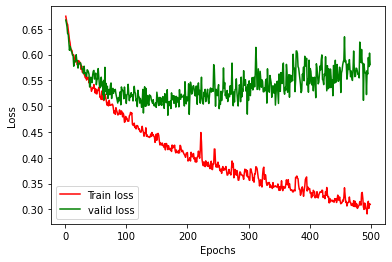

In [25]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,epochs)],[j.cpu().detach().numpy() for j in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

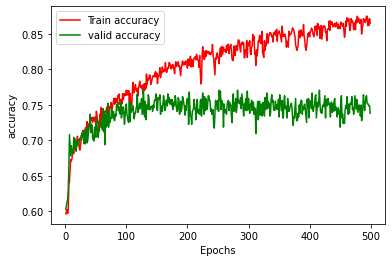

In [26]:
plt.plot([i for i in range(1,epochs)],[i  for i  in traine_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,epochs)],[j for j in vale_accuracy],label="valid accuracy",color="Green")
plt.v
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()

In [128]:
### loss
print(f"Training loss|   Mean: {torch.tensor(epoch_loss).mean()}   std: {torch.tensor(epoch_loss).std()}")
print(f"validation loss| Mean: {torch.tensor(valida_loss).mean()}  std: {torch.tensor(valida_loss).std()}")

Training loss|   Mean: 0.5562186241149902   std: 0.05334069952368736
validation loss| Mean: 0.5852508544921875  std: 0.04255188629031181


In [130]:
### Accuracy
print(f"Training accuracy|   Mean: {torch.tensor(traine_accuracy).mean()}   std: {torch.tensor(traine_accuracy).std()}")
print(f"validation accuracy| Mean: {torch.tensor(vale_accuracy).mean()}  std: {torch.tensor(vale_accuracy).std()}")

Training accuracy|   Mean: 0.7091323390151515   std: 0.052472118473039724
validation accuracy| Mean: 0.6945825441919192  std: 0.04727569250179902
